# Time series analysis

## visualitation and clean data 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import bokeh as bk 
import os
import seaborn as sns 

In [2]:
def listar_archivos(ruta='.'):
    return os.listdir(ruta)

In [6]:
# Customize your graphs
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,  # 'True' debe ser sin comillas para ser un valor booleano
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,  # 'rigth' debe corregirse a 'right'
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': 1,  # '1' debe ser un valor numérico
    'text.color': '0.9',  # 'text color' debe corregirse a 'text.color'
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12
}

plt.rcParams.update(dark_style)

In [8]:
import yfinance as yd
import datetime as dt 
########## price actions micron tecnology
ticket = 'MU'
start_day = '2017-01-01'
last_day = (dt.datetime.now()-dt.timedelta(days=1)).strftime("%Y-%m-%d")
micron_tech = yd.download(ticket, start_day, last_day)

[*********************100%%**********************]  1 of 1 completed


In [9]:
micron_tech.index = pd.to_datetime(micron_tech.index, dayfirst = True)
micron_tech=micron_tech.asfreq('b')
micron_tech = micron_tech.fillna(method='ffill')
micron_tech.head(5)

C:\Users\eduar\AppData\Local\Temp\ipykernel_25544\484190497.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  micron_tech = micron_tech.fillna(method='ffill')


Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2017-01-03  22.070000  22.740000  22.049999  22.549999  22.198050  24962900.0
2017-01-04  22.670000  22.840000  22.250000  22.360001  22.011019  20426800.0
2017-01-05  22.400000  22.570000  21.959999  22.110001  21.764921  19759400.0
2017-01-06  22.270000  22.280001  21.980000  22.040001  21.696014  17782200.0
2017-01-09  21.940001  22.549999  21.940001  22.340000  21.991329  21537200.0

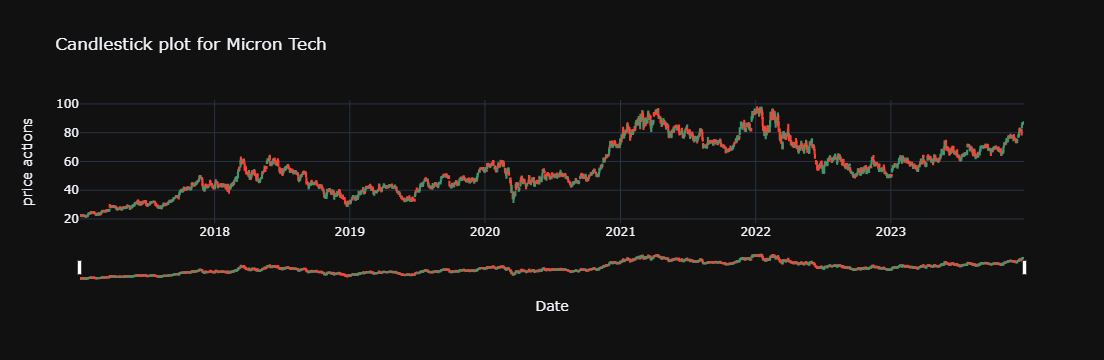

In [10]:
import plotly.express as px 
import plotly.graph_objects as go 

fig = go.Figure(data=go.Candlestick(x=micron_tech.index, 
            open=micron_tech['Open'],
            high=micron_tech['High'],
            low=micron_tech['Low'],
            close=micron_tech['Close']))
fig.update_layout(title='Candlestick plot for Micron Tech',
                  xaxis_title='Date',
                  yaxis_title='price actions',
                 template='plotly_dark')

fig.show()

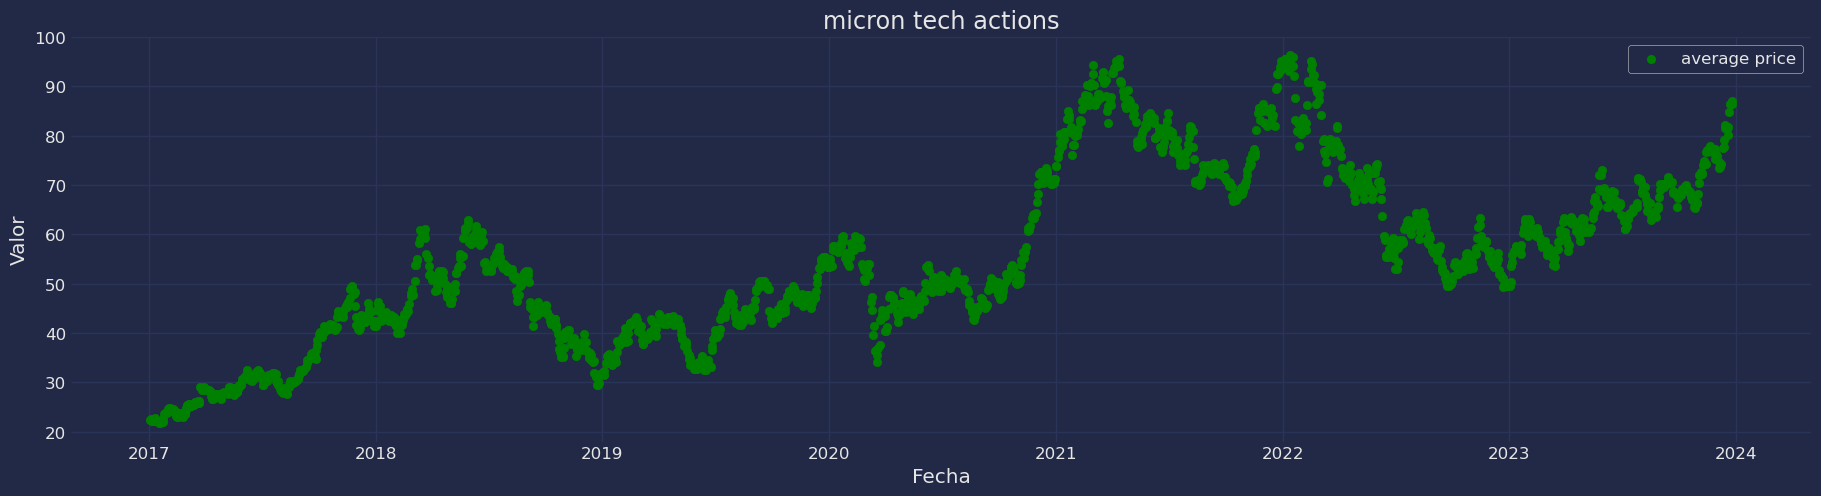

In [11]:
average_price = (micron_tech['Open'] + micron_tech['High'] + micron_tech['Close'] + micron_tech['Low'])/4

plt.figure(figsize=(20,5))
plt.scatter(average_price.index, average_price, color='green', label='average price')
#plt.plot(fc, color='green', label='arma predict')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

## trend analysis 

### Regresion Method 

In [12]:
### build a new vctor  for trend analysis 
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
y = average_price.copy()
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    drop=True)
X=dp.in_sample()

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(y.index, test_size=int(len(y.index)*0.15), shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


In [14]:
regresion_model = LinearRegression(fit_intercept=False)
regresion_model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    regresion_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

y_pred = pd.DataFrame(
    regresion_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)

In [15]:
###function to evaluate 
def metrics_to_eval(real_val,fit_val):
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    
    resid2=r2_score(real_val, fit_val)
    mean_abs = mean_absolute_error(real_val, fit_val)
    squared_err = mean_squared_error(real_val, fit_val)
    
    print('the r2 score is:', resid2)
    print('the mean absolute error is:', mean_abs)
    print('the mean squared error is:', squared_err)



In [16]:
metrics_to_eval(y_train, y_fit)

the r2 score is: 0.5770791044026187
the mean absolute error is: 9.75055978202498
the mean squared error is: 138.94644397780482


In [17]:
metrics_to_eval(y_test, y_pred)

the r2 score is: -1.8374227147258622
the mean absolute error is: 11.106857776588738
the mean squared error is: 155.3586467493398


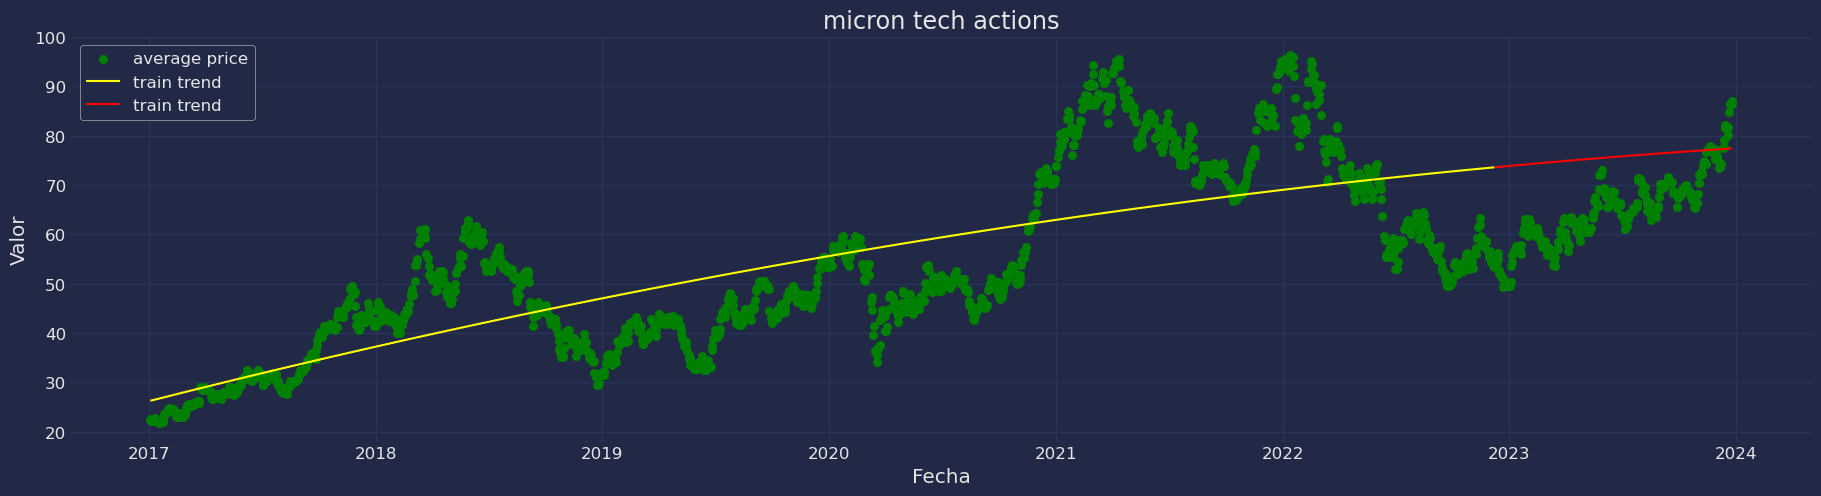

In [18]:
plt.figure(figsize=(20,5))
plt.scatter(average_price.index, average_price, color='green', label='average price')
plt.plot(y_fit, color="yellow", label='train trend')
plt.plot(y_pred, color="red", label='train trend')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

### Loees Regression 
(locally weigthed runing line smother)

In [19]:
import statsmodels.api as sm 
lowees = sm.nonparametric.lowess 
z = lowees(average_price, X.trend,
          frac=0.2,
          it=4)
serie_components = pd.DataFrame(z, columns=['constant', 'loess trend'])
serie_components.index = micron_tech.index

In [20]:
serie_components.head()

constant  loess trend
Date                             
2017-01-03       1.0    21.078670
2017-01-04       2.0    21.159883
2017-01-05       3.0    21.241135
2017-01-06       4.0    21.322424
2017-01-09       5.0    21.403752

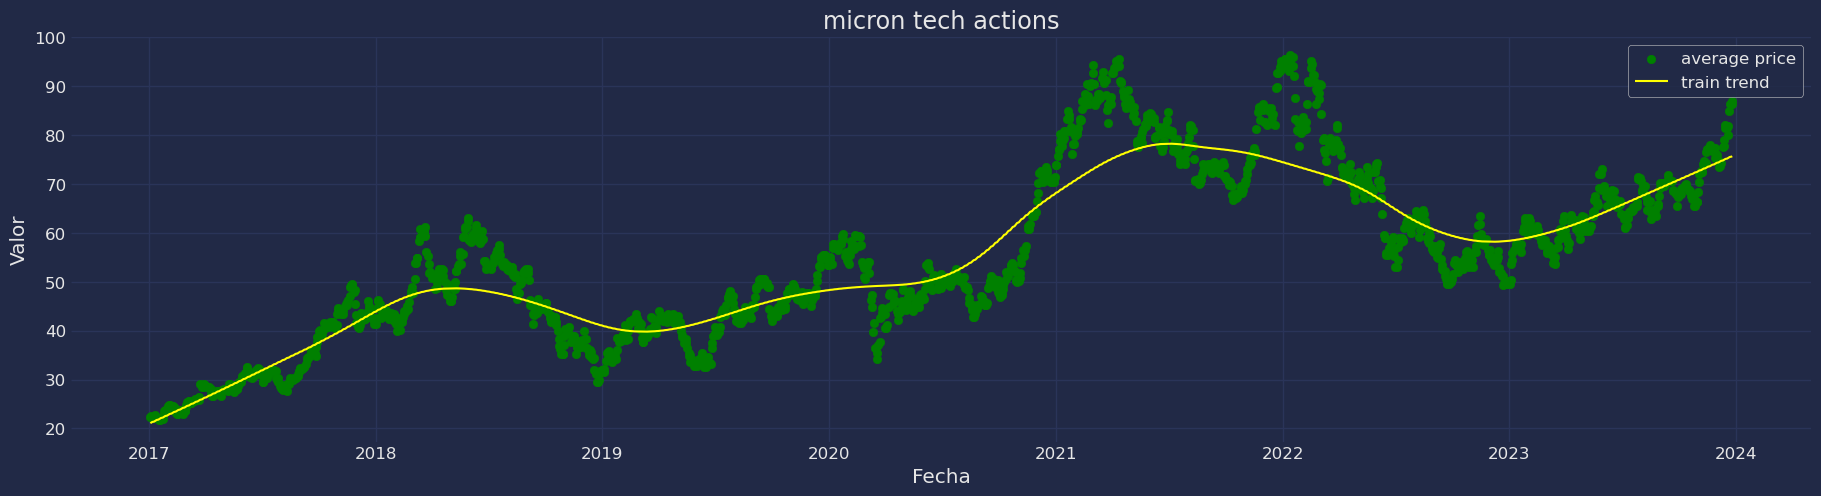

In [21]:
plt.figure(figsize=(20,5))
plt.scatter(average_price.index, average_price, color='green', label='average price')
plt.plot(serie_components['loess trend'], color="yellow", label='train trend')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

In [22]:
metrics_to_eval(average_price, serie_components['loess trend'])

the r2 score is: 0.8674757180696343
the mean absolute error is: 4.683664509258677
the mean squared error is: 40.29618144029187


## Seasonality analysis

In [23]:
##remove loess trend 
serie_components['trend loess remove'] = (average_price- serie_components['loess trend'])
### remove cuadratic trend
regresion_model.fit(X, average_price)
serie_components['cuadratic trend'] = regresion_model.predict(X) ### fit the cuadratic trnd for all data
serie_components['cuadratic remove'] = (average_price-serie_components['cuadratic trend'])

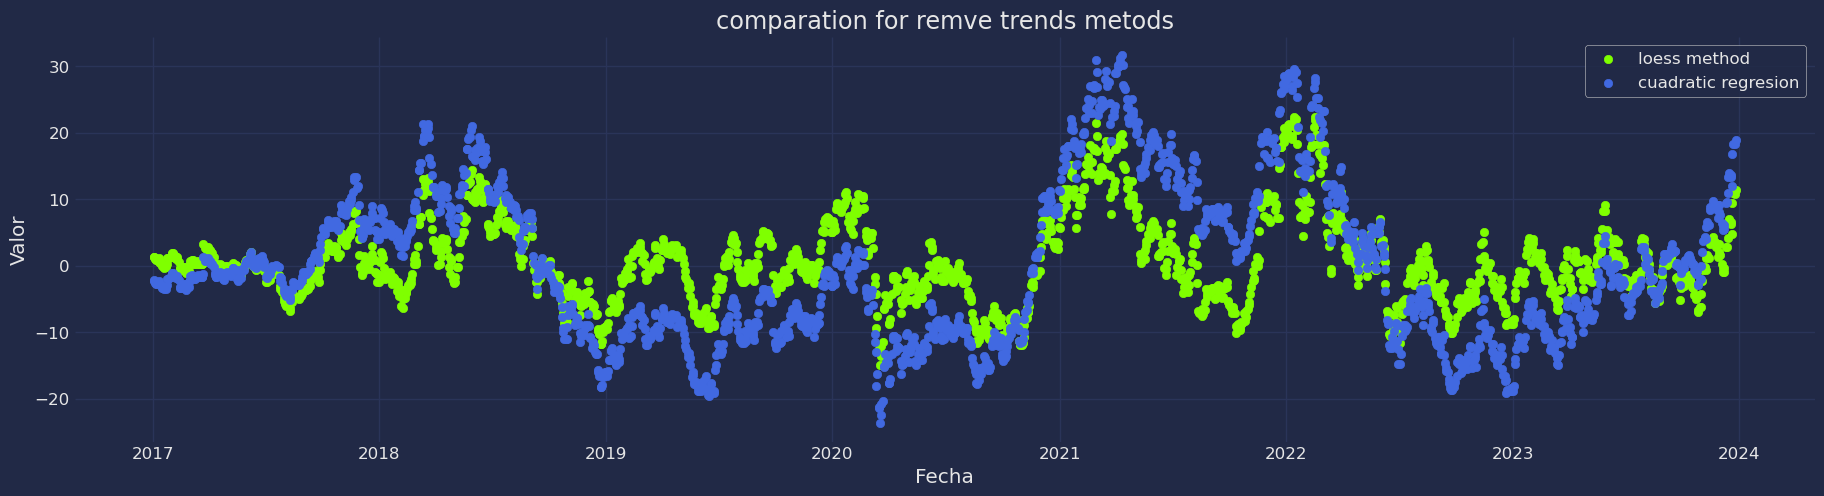

In [24]:
plt.figure(figsize=(20,5))
plt.scatter(average_price.index, serie_components['trend loess remove'], color='#7FFF00', label='loess method')
plt.scatter(average_price.index, serie_components['cuadratic remove'], color='#4169E1', label='cuadratic regresion')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('comparation for remve trends metods')
plt.grid(True)
plt.show()

### fourier trend method  

In [25]:
##periodogram 
def plot_periodogram(ts, detrend='constant', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("260D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

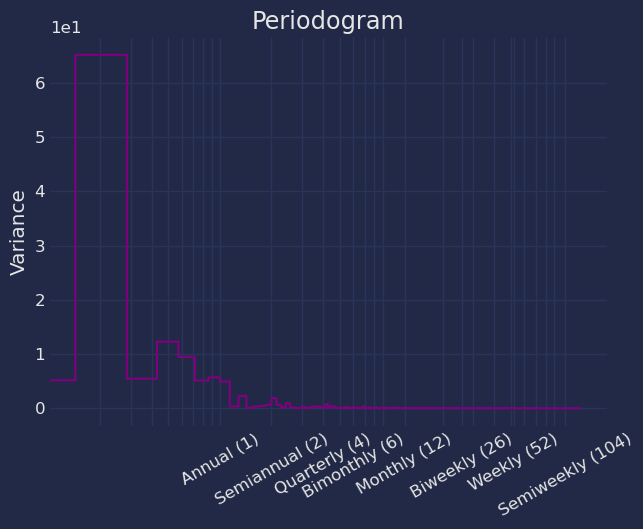

In [26]:
plot_periodogram(serie_components['cuadratic remove'])

In [27]:
fourier = CalendarFourier(freq='a', order=12)

In [28]:
dp = DeterministicProcess(
    index=serie_components.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  #

In [29]:
y= serie_components['cuadratic remove']
## train_test_split method
idx_train, idx_test = train_test_split(y.index, test_size=int(len(y.index)*0.10), shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

#####sesonal_train
regresion_model = LinearRegression(fit_intercept=False)
regresion_model.fit(X, y)

y_fit = pd.DataFrame(
    regresion_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

y_pred = pd.DataFrame(
    regresion_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)

In [30]:
metrics_to_eval(y_train, y_fit)

the r2 score is: 0.05550016351576603
the mean absolute error is: 9.814033595033871
the mean squared error is: 133.8958932310606


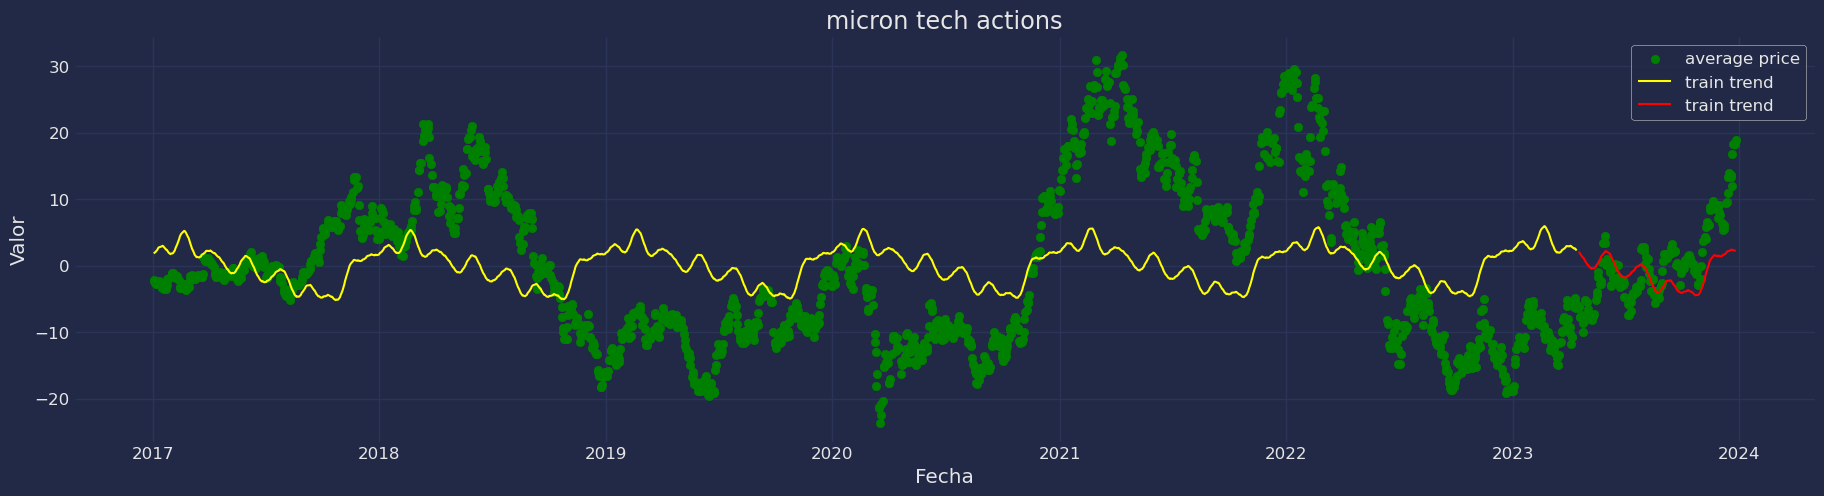

In [31]:
plt.figure(figsize=(20,5))
plt.scatter(y.index, y, color='green', label='average price')
plt.plot(y_fit, color="yellow", label='train trend')
plt.plot(y_pred, color="red", label='train trend')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

In [32]:
serie_components['seasonal regresion'] = regresion_model.predict(X)
serie_components['regresion residual'] = serie_components['cuadratic remove']-serie_components['seasonal regresion']

## Loess Method for seasonal

In [33]:
z = pd.DataFrame(lowees(serie_components['trend loess remove'], X.trend,
          frac=0.09,
          it=4))
z.index = serie_components.index
del z[0]
serie_components = serie_components.join(z)

In [34]:
serie_components.head()

constant  loess trend  trend loess remove  cuadratic trend  \
Date                                                                     
2017-01-03       1.0    21.078670            1.273830        24.697571   
2017-01-04       2.0    21.159883            1.370117        24.750669   
2017-01-05       3.0    21.241135            1.018865        24.803734   
2017-01-06       4.0    21.322424            0.820076        24.856768   
2017-01-09       5.0    21.403752            0.788748        24.909770   

            cuadratic remove  seasonal regresion  regresion residual         1  
Date                                                                            
2017-01-03         -2.345071            1.834104           -4.179175  0.880288  
2017-01-04         -2.220668            1.923495           -4.144163  0.873078  
2017-01-05         -2.543735            1.994294           -4.538029  0.865841  
2017-01-06         -2.714268            2.066460           -4.780728  0.858575  
2017-01-09         -2.717269            2.417153           -5.134423  0.851280

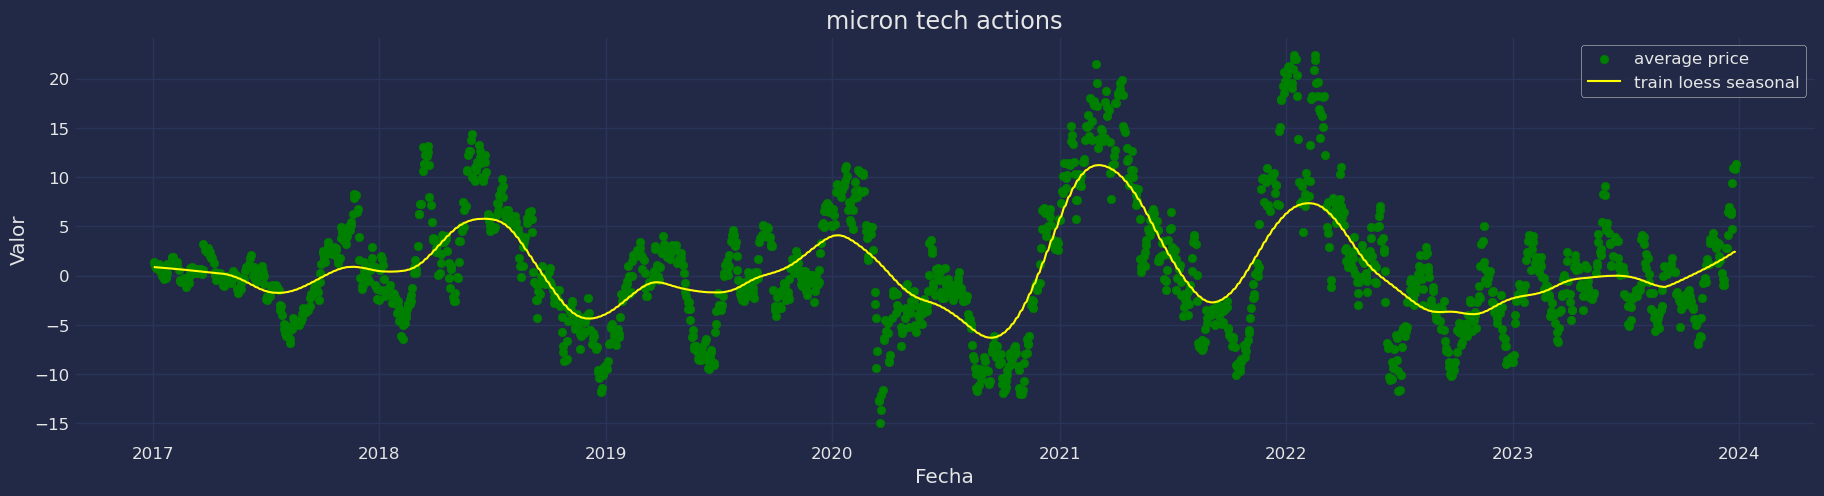

In [35]:
plt.figure(figsize=(20,5))
plt.scatter(serie_components['trend loess remove'].index, serie_components['trend loess remove'] , color='green', label='average price')
plt.plot(serie_components[1], color="yellow", label='train loess seasonal')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

In [36]:
serie_components['residual Loess'] = serie_components['trend loess remove'] - serie_components[1]

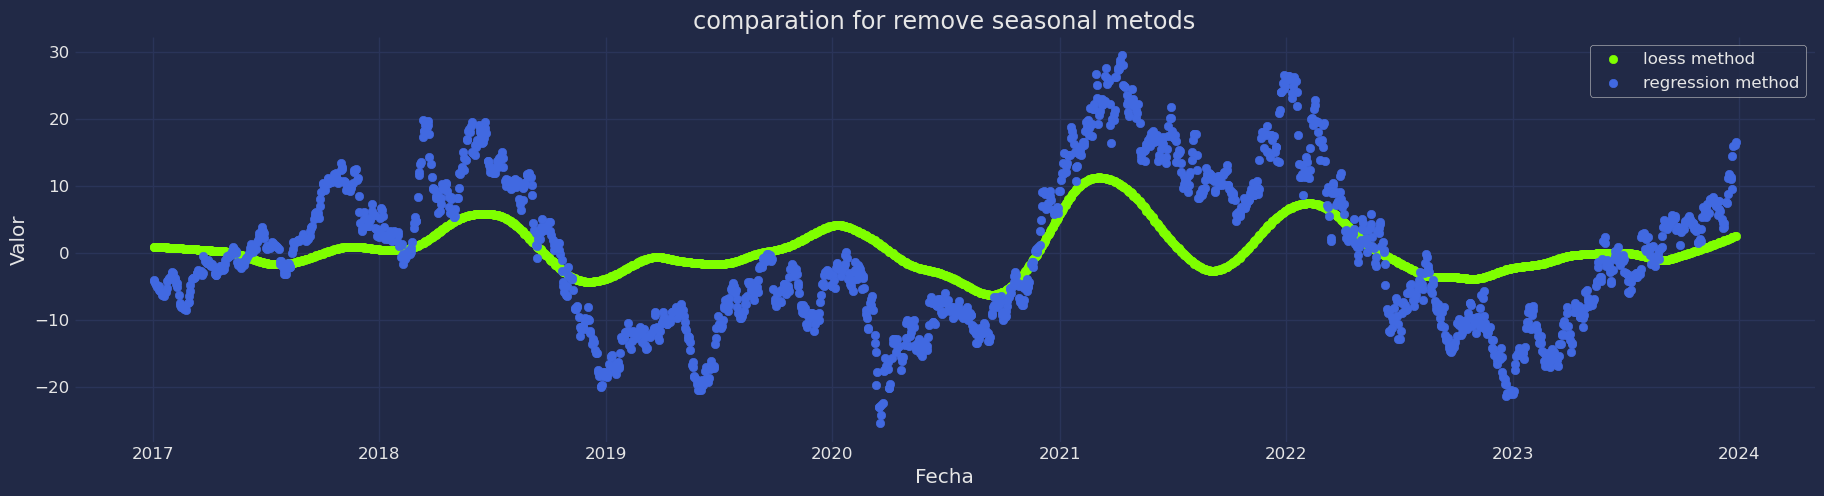

In [37]:
plt.figure(figsize=(20,5))
plt.scatter(average_price.index, serie_components[1], color='#7FFF00', label='loess method')
plt.scatter(average_price.index, serie_components['regresion residual'], color='#4169E1', label='regression method')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('comparation for remove seasonal metods')
plt.grid(True)
plt.show()

In [38]:
serie_components['T + S regresions'] = serie_components['cuadratic trend'] + serie_components['seasonal regresion']
serie_components['T + S loess'] = serie_components['loess trend'] + serie_components[1]

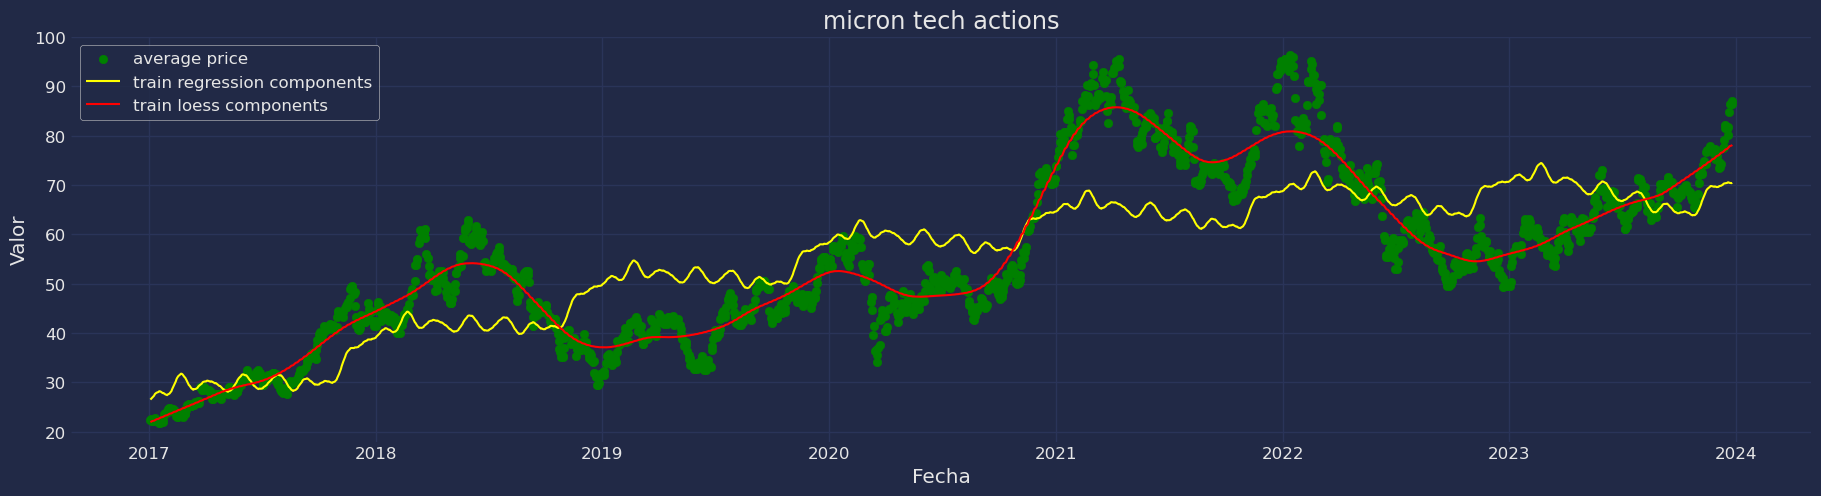

In [39]:
plt.figure(figsize=(20,5))
plt.scatter(average_price.index, average_price , color='green', label='average price')
plt.plot(serie_components['T + S regresions'], color="yellow", label='train regression components')
plt.plot(serie_components['T + S loess'], color="red", label='train loess components')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('micron tech actions')
plt.grid(True)
plt.show()

In [40]:
metrics_to_eval(average_price, serie_components['T + S regresions'])

the r2 score is: 0.593601478757387
the mean absolute error is: 9.286174784018364
the mean squared error is: 123.57213569105399


In [41]:
metrics_to_eval(average_price, serie_components['T + S loess'])

the r2 score is: 0.9465262719140526
the mean absolute error is: 3.0271695630439694
the mean squared error is: 16.259564042553276


In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_simple = seasonal_decompose(average_price.fillna(method='bfill'), model='aditive') 

C:\Users\eduar\AppData\Local\Temp\ipykernel_25544\3432167350.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [43]:
trend=seasonal_simple.trend
seasonal =seasonal_simple.seasonal
cycle = seasonal_simple.resid

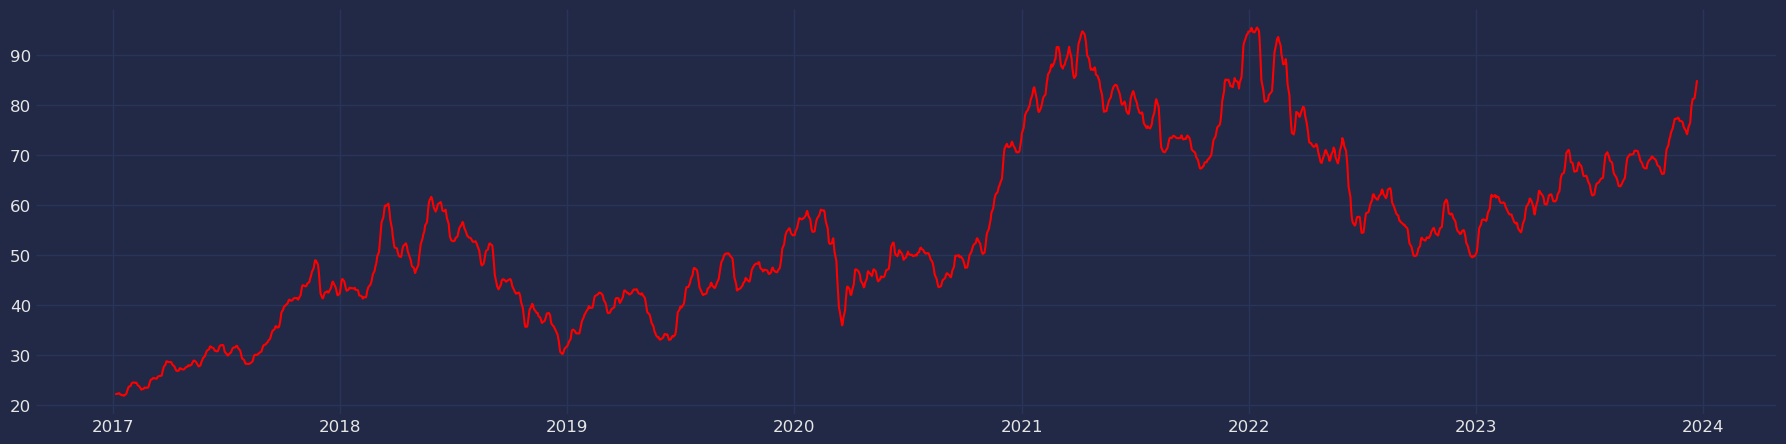

In [44]:
plt.figure(figsize=(20,5))
plt.plot(trend + seasonal, color='red')

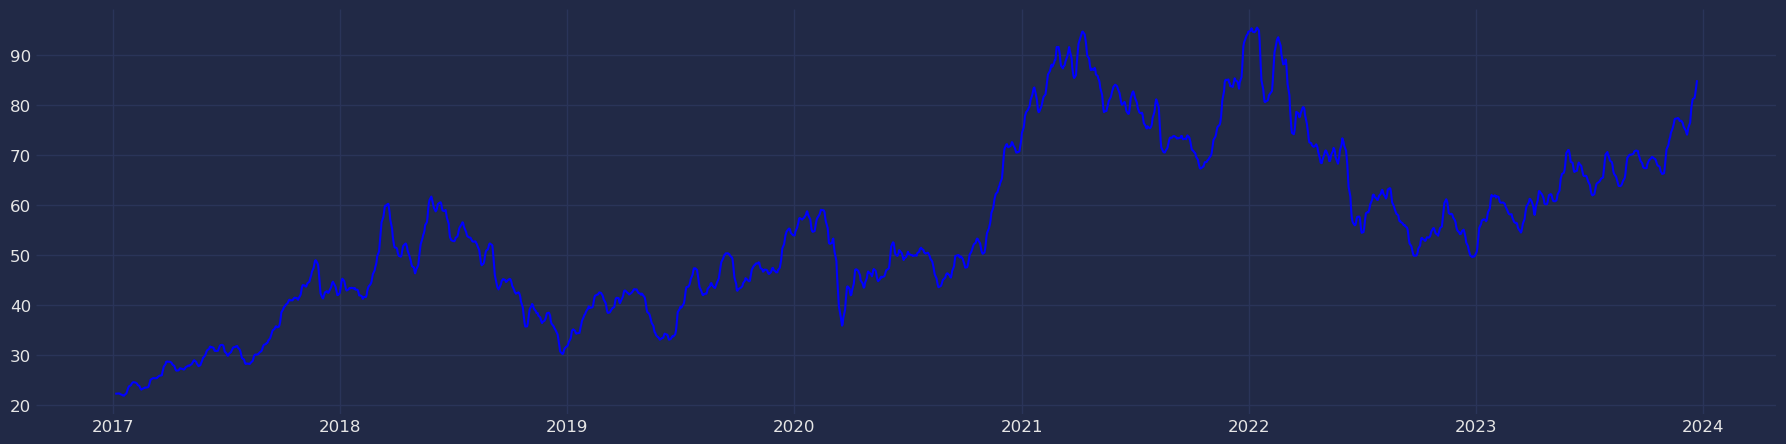

In [45]:
plt.figure(figsize=(20,5))
plt.plot(trend, color='blue')

## Estacionariedad de una serie de tiempo.

### condición de igualdad
$X_t = X_{t-1}-\epsilon_t$


$X_t - X_{t-1} =  \epsilon_t$

$\triangle X =  \epsilon_t$

In [46]:
dickey_dataset = average_price.copy()
dickey_dataset = pd.DataFrame(index = average_price.index, data=average_price, columns=['price'])
dickey_dataset['lag1'] = dickey_dataset['price'].shift(1)

In [47]:
dickey_dataset = dickey_dataset.dropna()
dickey_dataset['diference'] = dickey_dataset['price'] - dickey_dataset['lag1'] 

In [48]:
regresion_model = LinearRegression(fit_intercept=False)
y=pd.DataFrame(dickey_dataset['price'])
x=pd.DataFrame(dickey_dataset['lag1'])
dickey_model = regresion_model.fit(y, x)

### Regla de desición
$\{$ $h1 :$ $si$ $\phi$ $= 1$ $es \,aleatoria$ 

$\{$ $h0 : \,si$ $\phi$ $< 1$ $es \, estacionaria$

In [49]:
phi_param = dickey_model.coef_
print(phi_param)

[[0.9991755]]


### prueba de alpha 
$\alpha$ = $(1-\phi)$

$\{$ $h1 :$ $si$ $\alpha$ $= 0$ $es \,aleatoria$ 

$\{$ $h0 :$ $si$ $\alpha$ $< 0$ $es \,aleatoria$ 

In [50]:
alpha = (phi_param-1)
alpha

array([[-0.0008245]])

### prueba estacionaria con python

In [55]:
from statsmodels.tsa.stattools import adfuller 
adfuller(average_price, regression='ct', autolag='aic')

(-2.7518325694834926,
 0.21519731152523952,
 1,
 1819,
 {'1%': -3.9637555793912167,
  '5%': -3.412906372335286,
  '10%': -3.1284726303149317},
 5961.369985285503)

In [52]:
adfuller(dickey_dataset['diference'])

(-35.34573021470681,
 0.0,
 0,
 1819,
 {'1%': -3.4339500836471712,
  '5%': -2.8631302362582534,
  '10%': -2.567616588375528},
 5962.436020843087)

#### prueba de Sargan Barghaba. 

In [58]:
num1 = sum(dickey_dataset['diference'])
num2 = sum(average_price - average_price.mean())
estat = num1/num2
print(estat)

158486230252.94968
